# Learning objective

This notebook illustrates the soliton solutions of the nonlinear Schr&ouml;dinger (NLS) equation and its dynamic properties.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata
from scipy import optimize

# to save plots as files and download them
from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# The nonlinear Schrödinger equation

Consider
$$ i A_\tau = A_{zz} + |A|^2A $$
on the spatial interval $z_\mathrm{min}\le z \le z_\mathrm{max}$ subject to prediodic boundary conditions
$$ A(z_\mathrm{min},\tau) = A(z_\mathrm{max},\tau), $$
and to be integrated from $\tau=0$ up to $\tau_\mathrm{max}$.

Note that $A(z,\tau)$ is complex, so that $|A|^2=A^*A$, where $A^*$ is the complex conjugate.

In [2]:
# spatial interval
# using integer multiples of pi to make it easier to consider periodic IC
zmin = -5*np.pi
zmax = 15*np.pi

# number of grid points in discretization
N = 650
# grid spacing
h = (zmax-zmin)/N
# the grid
zj = np.linspace(zmin,zmax,num=N,endpoint=False)

# simualtion total run time
tmax = 40

## Envelope soliton

NLS has an exact solution in the form of an _envelope soliton_:
$$
  A(z,\tau) = a(z - v_e \tau) e^{i\theta(z - v_p \tau)}
$$
for any given "envelope velocity" $v_e$ and "phase velocity" $v_p$. The quotes are to reminds are these are descriptive terms, not physical interpretations.

After a lot of work (see Chapter 3.2 of Dauxois &amp; Peyrard's book), one obtains
$$
  A(z,\tau) = A_0 \, \mathrm{sech}\left(\frac{z-z_0-v_e\tau}{\sqrt{2}/A_0}\right) e^{-i\big( (z - v_p \tau)v_e/2 - \varphi_0 \big)},
$$
where
$$
  A_0 = \sqrt{\frac{v_e^2 - 2v_e v_p}{2}}.
$$

All the quantities with subscripts are **constant** parameters.

<u>Comments:</u>

*   $A_0e^{i\varphi_0}$ is the complex amplitude of the envelope soliton, so $A_0$ is the (real) magnitude of $|A|$, $\varphi_0\in[0,2\pi]$ is an arbitrary phase.
*   $v_e$ is the velocity of the peak of the envelope, which should also be real.
*   $v_e$ and $v_p$ can be independently either positive or negative (right- or left-going propagation).
*   We must have $v_e^2 - 2v_e v_p > 0$, which means hat $v_p = v_e$ is not allowed, but $v_p=0$ is.
*   The envelope's magnitude $A_0$ is a function of the velocities $v_e$, and $v_p$. Or, vice versa.
*   $z_0$ is the spatial shift of the peak, it is also real.

Let us eliminate $v_e$ in favor of $A_0$ and $v_p$. This would be nicer. After all, we know a nonlinear wave has a speed $v_e$ that is a function of its amplitude $A_0$ (and, for NLS, $v_p$). Then,
$$
  v_e = v_p \pm \sqrt{v_p^2 + 2A_0^2}.
$$
Let us take the "$+$" for definiteness, which is the right-going soliton.

In [3]:
# the envelope soliton
def soliton(z,t,z0,A0,vp,phi0):
  ve = vp + np.sqrt(vp**2 + 2*A0**2)
  # to make the output periodic on [zmin,zmax]
  z = z + (zmax-zmin)/2
  arg = (z-z0-ve*t)%(zmax-zmin)
  arg = (zmax-zmin)/2 - arg
  return A0/np.cosh(A0/np.sqrt(2)*arg)*np.exp(-1j*((z-vp*t)*ve/2-phi0))

Let us visualize this solution at $\tau=0$, which means that both $v_e$ and $v_p$ drop out, and do not affect the shape.

In [4]:
def plot_soli(z0,A0):
  ax = plt.gca()
  u = soliton(zj,0,z0,A0,0,0)
  ax.plot(zj, np.abs(u), color='black', linewidth=2)
  ax.set_ylabel('$|A|$')
  ax.set_xlabel('$z$')
  ax.set_xlim(zmin,zmax)
  plt.show()

interact(plot_soli, z0 = widgets.FloatSlider(value=0, min=-50, max=50, step=2),
                    A0 = widgets.FloatSlider(value=1, min=0.2, max=5, step=0.1) );

interactive(children=(FloatSlider(value=0.0, description='z0', max=50.0, min=-50.0, step=2.0), FloatSlider(val…

In [5]:
# another way to plot the complex A
def plot_soli(z0,A0,ϕ0):
  fig, ax1 = plt.subplots(figsize=(7,4))

  u = soliton(zj,0,z0,A0,0,ϕ0)

  # Re[A] on the left axis
  ax1.plot(zj, np.real(u), color='blue', lw=2)
  ax1.set_ylabel('Re[$A$]', color='blue')
  ax1.set_xlabel('$z$')
  ax1.set_xlim(zmin,zmax)
  ax1.tick_params(axis='y', labelcolor='blue')

  # Im[A] on the right axis
  ax2 = ax1.twinx()
  ax2.plot(zj, np.imag(u), color='red', lw=2)
  ax2.set_ylabel('Im[$A$]', color='red')
  ax2.tick_params(axis='y', labelcolor='red')

  plt.show()

interact(plot_soli, z0 = widgets.FloatSlider(value=0, min=-20, max=20, step=1),
                    A0 = widgets.FloatSlider(value=1, min=0.5, max=5, step=0.2),
                    ve = widgets.FloatSlider(value=1, min=-3, max=3, step=0.2),
                    ϕ0 = widgets.FloatSlider(value=0, min=0, max=2*np.pi, step=0.1) );

interactive(children=(FloatSlider(value=0.0, description='z0', max=20.0, min=-20.0, step=1.0), FloatSlider(val…

## The initial condition

**Choice 1:** a flat initial condition that suffers from the [modulation instability](https://www.sciencedirect.com/science/article/pii/S0167278908004223).

In [6]:
ic_type = 'modinst'
# need kic < sqrt(2) ?
kic = 10/15
Aic = 1 + 0.001*(np.exp(-1j*kic*zj)+np.exp(1j*kic*zj))

**Choice 2:** a two-soliton initial condition, by linear superposition of two well-spaced shapes.

Note, in particular, the two solitons need to be far enough apart from each and from the boundaries so that their "tails" have decayed to $\approx0$ in both directions.

For simplicity, we take $v_p=0$ and $\phi_0=0$.

In [7]:
ic_type = '2soli'
# define the superposition via a function for all t
def twosoli(x,t):
  # args: z, t, z0, A0, vp, phi0
  return soliton(zj,t,-5,2,0,0) + soliton(zj,t,28,1,0,0)
# evaluate at t = 0 for the initial conditon
Aic = twosoli(zj,0)

Whichever initial condition we chose, let's plot it.

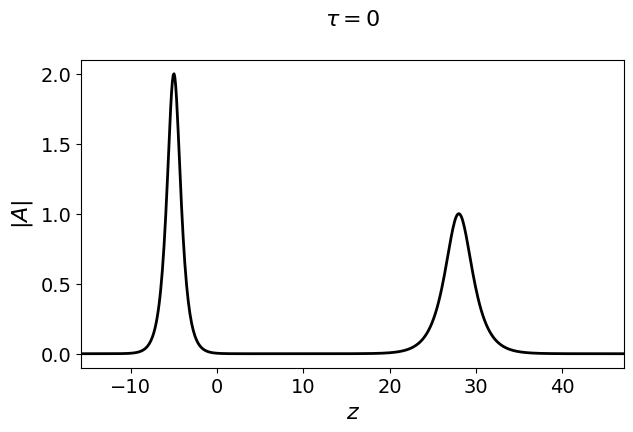

In [8]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(zj, np.abs(Aic), lw=2, color='black')
ax1.set_ylabel('$|A|$')
if ic_type == 'modinst':
  ax1.set_ylim(-0.1,1.1)
ax1.set_xlabel('$z$')
ax1.set_xlim(zmin,zmax)
ax1.set_title('$\\tau=0$');

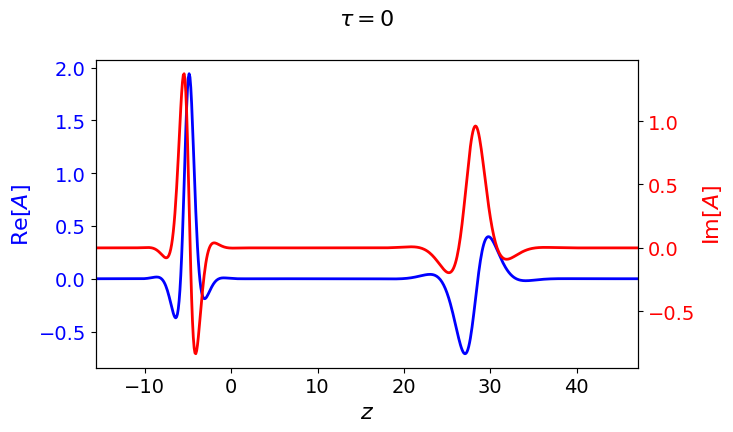

In [9]:
# another way to plot the complex A
fig, ax1 = plt.subplots(figsize=(7,4))

# Re[A] on the left axis
ax1.plot(zj, np.real(Aic), color='blue', lw=2)
ax1.set_ylabel('Re[$A$]', color='blue')
ax1.set_xlabel('$z$')
ax1.set_xlim(zmin,zmax)
ax1.tick_params(axis='y', labelcolor='blue')

# Im[A] on the right axis
ax2 = ax1.twinx()
ax2.plot(zj, np.imag(Aic), color='red', lw=2)
ax2.set_ylabel('Im[$A$]', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('$\\tau=0$');

# Numerical solution

The semi-discrete problem we wish to solve using the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) is
$$ \dot{A}_j = \frac{1}{i}\left[ \left(\frac{A_{j+1} +2A_j - A_{j-1}}{h^2}\right) + |A_j|^2A_j \right],\qquad j=0,\dots,N-1, $$
so that $A_j(\tau) \approx A(z_j,\tau)$. As usual, $j=N$ is not included because, by periodic BCs, $u_0=u_{N}$ are the _same_ gridpoint.

In [10]:
# ODE system right-hand side
def NLSE(t,u):
  F = np.empty(N, dtype=complex)

  # boundary nodes require special care
  F[0] = (u[1] - 2*u[0] + u[N-1])/h**2 + np.abs(u[0])**2*u[0]
  F[N-1] = (u[0] - 2*u[N-1] + u[N-2])/h**2 + np.abs(u[N-1])**2*u[N-1]

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j] = (u[j+1] - 2*u[j] + u[j-1])/h**2 + np.abs(u[j])**2*u[j]

  return F/1j

Note that the `Radau` and `LSODA` methods from `solve_ivp` cannot be used in the complex domain.

In [11]:
# try: test different tolerances for the integrator, changing tol
tol = 1e-6

# simulate the PDE
sol = solve_ivp(fun=NLSE,
                t_span=[0,tmax], y0=Aic,
                method='DOP853', rtol=tol, atol=tol, dense_output=True)

# Results and visualization

First, just a quick static plot of the solution at the final time.

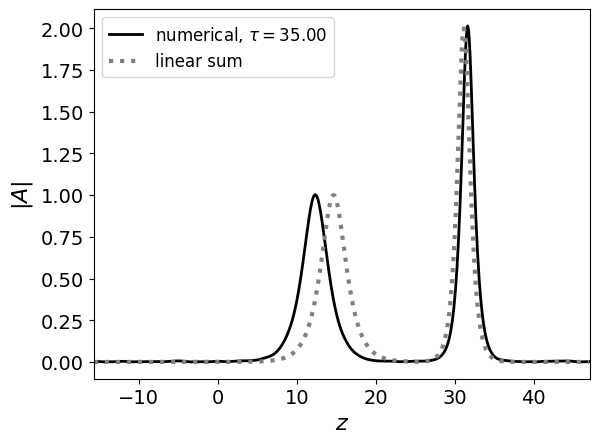

In [12]:
tplot = 35
Aj = sol.sol(tplot)

fig, ax = plt.subplots()
ax.plot(zj, np.abs(Aj), lw=2, color='black', label=f'numerical, $\\tau=${tplot:.2f}')
if ic_type == '2soli':
  Ajl = twosoli(zj,tplot)
  ax.plot(zj, np.abs(Ajl), lw=3, color='gray', ls='dotted', label='linear sum')

ax.set_ylabel('$|A|$')
#ax.set_ylim(-0.02,0.06)
ax.set_xlabel('$z$')
ax.set_xlim(zmin,zmax)
ax.legend();

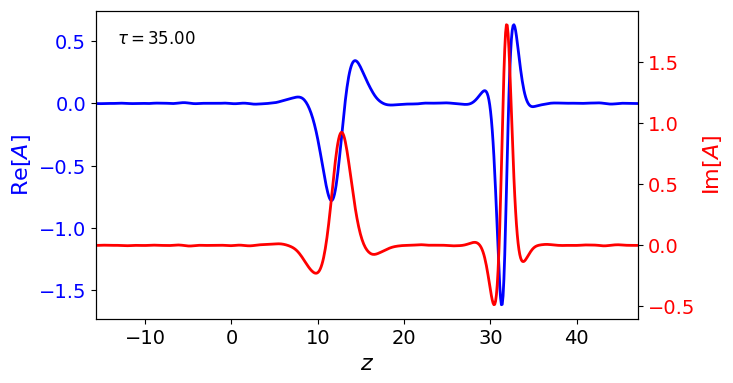

In [13]:
# another way to plot the complex A
fig, ax1 = plt.subplots(figsize=(7,4))

# Re[A] on the left axis
ax1.plot(zj, np.real(Aj), color='blue', lw=2)
ax1.set_ylabel('Re[$A$]', color='blue')
ax1.set_xlabel('$z$')
ax1.set_xlim(zmin,zmax)
#ax1.set_title(f'$\\tau=${tplot:.2f}')
ax1.text(0.075, 0.775, f'$\\tau=${tplot:.2f}', size='large',
         #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
         transform=ax.transAxes, animated=True)
ax1.tick_params(axis='y', labelcolor='blue')

# Im[A] on the right axis
ax2 = ax1.twinx()
ax2.plot(zj, np.imag(Aj), color='red', lw=2)
ax2.set_ylabel('Im[$A$]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

## Animation

Next, we visualize our results using our snazzy animation tools.

In [14]:
# define how to sample the solution in time
tnum = 200
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [15]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$|A|$')
if ic_type == '2soli':
  ax.set_ylim(0,2.5)
ax.set_xlabel('$z$')
ax.set_xlim(zmin,zmax)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(zj, 0*zj, color='black', lw=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  Aj = sol.sol(it*dt)
  line.set_data(zj, np.abs(Aj))
  ttl.set_text(f'$\\tau=${it*dt:.2f}')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Space-time plot

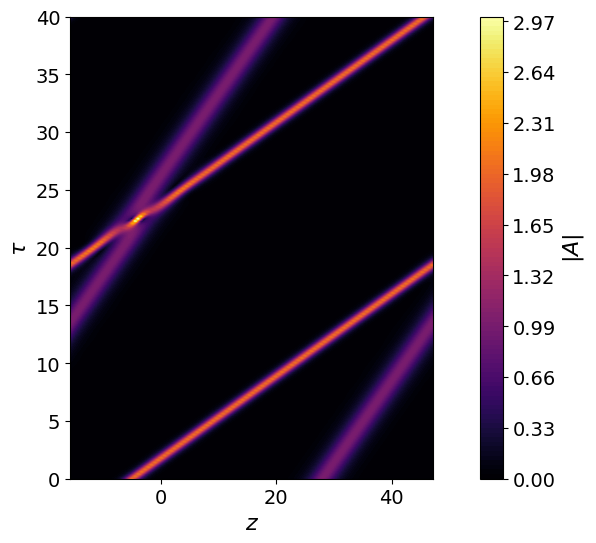

In [16]:
# make a matrix of space-time values u(x,t)
Ajp = np.empty((tnum,N))
for it in range(0,tnum):
  Ajp[it,:] = np.abs(sol.sol(it*dt))

# make cool plot with sequential cmap, try also 'hot' or 'plasma'
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(zj, tspan, Ajp, 100, cmap='inferno')
plt.colorbar(label='$|A|$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$\\tau$')
ax.set_xlim(zmin,zmax)
ax.set_xlabel('$z$')
ax.set_aspect(2/1)

For the `modinst` initial condition, we see the emergence of [rogue waves](https://physics.aps.org/articles/v2/86) of large amplitude out of the low-amplitude background.

For the `2soli` initial condition, the NLS envelope solitons interact "elastically" (preserve their shape and speed), much like the KdV ones. They "pass through" each other and continue their steady propagation, save for a phase shift.

# Conservation properties of the solution

With a bit more effort than usual (or referring to Dauxois &amp; Peyrard's textbook, Chapter 3.3), one can show that:
1.   the "intensity" $\int_{z_\mathrm{min}}^{z_\mathrm{max}} |A|^2 \, dz \approx const.$ for all $\tau\ge0$,
2.   the "energy" $\int_{z_\mathrm{min}}^{z_\mathrm{max}} (\tfrac{1}{2}|A|^4 - |A_z|^2 )\, dz \approx const.$ for all $\tau\ge0$.

are conserved.

To compute the integrals, we use the midpoint rule, and we approximate
$$ A_z(z_j,\tau) \approx \frac{A_{j+1}(\tau)-A_{j-1}(\tau)}{2h} $$
and use the periodic BCs.

Verifying these conservation properties  will give us confidence in our numerical solutions.

In [17]:
# define how to sample the solution in time
tnum = N
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [18]:
# compute the intensity and energy as functions of t
intensity = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  Aj = sol.sol(it*dt)
  Azj = ( np.concatenate((Aj[1:N],[Aj[0]])) \
          - np.concatenate(([Aj[N-1]],Aj[0:N-1])) )/(2*h)

  intensity[it] = h*np.sum(np.abs(Aj)**2)
                  #np.trapz(np.abs(Aj)**2,zj)
  energy[it] = h*np.sum(0.5*np.abs(Aj)**4 - np.abs(Azj)**2)
               #np.trapz(0.5*np.abs(Aj)**4 - np.abs(Azj)**2,zj)

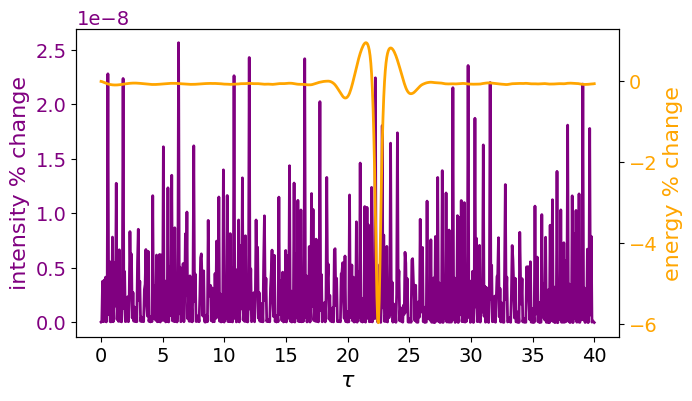

In [19]:
fig, ax1 = plt.subplots(figsize=(7,4))

# momentum on the left axis
ax1.plot(tspan, (intensity-intensity[0])/intensity[0]*100, lw=2, color='purple')
ax1.set_ylabel('intensity % change', color='purple')
ax1.set_xlabel('$\\tau$')
ax1.tick_params(axis='y', labelcolor='purple')

# energy on the right axis
ax2 = ax1.twinx()
ax2.plot(tspan, (energy-energy[0])/energy[0]*100, color='orange', lw=2)
ax2.set_ylabel('energy % change', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

As usually, central differences allow us to keep the intensity change close to 0%.

"Something" happens during the interaction and there's a large fluctuation of the energy in the field. In principle, the number of grid points and the tolerances on the time integrator control the energy change.

In [20]:
print('final energy % change is',(energy[-1]-energy[0])/energy[0]*100)

final energy % change is -0.056677630338595804


# Verifying the envelope soliton solution using SymPy

Let's try check the analytical solution symbolically with [SymPy](https://www.sympy.org/en/index.html).

In [21]:
# independent variables, make sure to explicitly state they're real!
z = sp.symbols('z', real=True)
# time should be positive
tau = sp.symbols('tau', positive=True)
# other vars/params/symbols, make sure to explicitly state they're real!
v_e, v_p, z0, phi0 = sp.symbols('v_e v_p z0 phi0', real=True)
# amplitude should be positive
A0 = sp.symbols('A0', positive=True)

# soliton, is complex-valued function of *real* variables
v_e = v_p + sp.sqrt(v_p**2 + 2*A0**2)
Asoli = A0/sp.cosh(A0/sp.sqrt(2)*(z-z0-v_e*tau)) \
        *sp.exp(-sp.I*((z-v_p*tau)*v_e/2+phi0))

In [22]:
# plug into NLS' LHS
LHS = sp.simplify(sp.I*sp.diff(Asoli,tau))
LHS

                                                                              
                                                                              
                              ⎛          ⎛      ⎛  ⎛        _____________⎞    
      ⎛        _____________⎞ ⎜          ⎜      ⎜  ⎜       ╱     2     2 ⎟    
      ⎜       ╱     2     2 ⎟ ⎜          ⎜√2⋅A₀⋅⎝τ⋅⎝vₚ + ╲╱  2⋅A₀  + vₚ  ⎠ - z
-ⅈ⋅A₀⋅⎝vₚ + ╲╱  2⋅A₀  + vₚ  ⎠⋅⎜√2⋅A₀⋅sinh⎜────────────────────────────────────
                              ⎝          ⎝                    2               
──────────────────────────────────────────────────────────────────────────────
                                                                             ⎛
                                                                             ⎜
                                                                            2⎜
                                                                      2⋅cosh ⎜
                                                    

In [23]:
# plug into NLS' RHS
RHS = sp.simplify(sp.diff(Asoli,z,z) + sp.Abs(Asoli)**2*Asoli)
RHS

                                                                              
                                                                              
   ⎛                                                                          
   ⎜    ⎛    ⎛      ⎛            _____________         ⎞⎞    ⎞                
   ⎜  2 ⎜    ⎜      ⎜           ╱     2     2          ⎟⎟    ⎟       2        
A₀⋅⎜A₀ ⋅⎝cosh⎝√2⋅A₀⋅⎝τ⋅vₚ + τ⋅╲╱  2⋅A₀  + vₚ   - z + z₀⎠⎠ - 3⎠ + 4⋅A₀  - √2⋅ⅈ⋅
   ⎝                                                                          
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              
                                                                              
                                                                              
                                                    

In [24]:
# check if NLS is satisfied
LHS.equals(RHS)

True

LHS = RHS, so it is a solution!

# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own are outlined here.

1.   What is the effect, if any, of nonzero $v_p$ and $\phi_0$ values on the two-soliton interaction?
2.   More efficient numerical methods for NLS are discussed in [Ch. 7 of J. Yang's book](https://epubs-siam-org.ezproxy.lib.purdue.edu/doi/10.1137/1.9780898719680.ch7). Implement the pseudospectral method and compare it to the method of lines, in particular in terms of conservation properties.

